In [374]:
%matplotlib inline
import pyspark
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import OneHotEncoder, StringIndexer, Normalizer
from pyspark.ml.pipeline import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param
from pyspark import keyword_only
from pyspark.ml import Pipeline
from pyspark.sql import Row
from pyspark.sql import SQLContext

In [375]:
sc = pyspark.SparkContext(master='local[*]')
sqlContext = SQLContext(sc)

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=pyspark-shell, master=local[*]) created by __init__ at <ipython-input-2-935071614592>:1 

In [376]:
pd.set_option('display.max_columns', 500)

In [377]:
shelter_pd = pd.read_csv('train.csv')

In [378]:
shelter_pd

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan
5,A677334,Elsa,2014-04-25 13:04:00,Transfer,Partner,Dog,Intact Female,1 month,Cairn Terrier/Chihuahua Shorthair,Black/Tan
6,A699218,Jimmy,2015-03-28 13:11:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Tabby
7,A701489,NaN,2015-04-30 17:02:00,Transfer,Partner,Cat,Unknown,3 weeks,Domestic Shorthair Mix,Brown Tabby
8,A671784,Lucy,2014-02-04 17:17:00,Adoption,NaN,Dog,Spayed Female,5 months,American Pit Bull Terrier Mix,Red/White
9,A677747,NaN,2014-05-03 07:48:00,Adoption,Offsite,Dog,Spayed Female,1 year,Cairn Terrier,White


## Análisis de datos

En primer lugar es necesario analizar los datos. Por ello, se considera apropiado realizar el Data Quality Report.

In [379]:
shelter_pd.describe(include = "all")

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


El Data Quality Report nos da un análisis de los datos. Tenemos 26729 filas en el dataset y se puede ver que hay un missing value en la columna SexuponOutcome (<1%), 18 en AgeuponOutcome (<1%), 7691 en Name (~28.7%) y 13612 en OutcomeType(~50.9%).

Como vamos a manejar el problema de los missing values?

- En el caso de SexuponOutcome, podemos simplemente borrar las filas porque no va a afectar nuestro modelo de predicciones.
- En el caso de AgeuponOutcome, vamos a borrar las filas también porque son muy pocos datos (<1%).
- En el caso de Name, no nos importa porque no vamos a usar esa columna en nuestro modelo. (El nombre no influye el Outcome del animal..)
- En el caso de OutcomeSubtype, tenemos muchos missing value porque por algunos valores de OutcomeType, como por ejemplo <i>Return_to_owner</i>, no hacía falta poner más información.

Que tipo de transformaciones vamos a aplicar sobre los datos para que se pueda usar para crear un modelo de predicción?
- Name: Borramos la columna porque no nos interesa en nuestras predicciones.
- OutcomeType: Es un feature categórica entonces vamos a aplicar el StringIndexer para que lo transforme a feature numérica.
- OutcomeSubtype: Borramos la columna porque no nos interesa en nuestras predicciones.
- AnimalType: Es un feature categórica entonces vamos a aplicar el StringIndexer para que lo transforme a feature numérica.
- SexuponOutcome: Es un feature categórica entonces vamos a aplicar el StringIndexer para que lo transforme a feature numérica.
- AgeuponOutcome: Vamos a convertir cada edad en semana para que todos los datos tengan la misma MEDIDA??
- Breed: Es un feature categórica entonces vamos a aplicar el StringIndexer para que lo transforme a feature numérica.
- Color: Es un feature categórica entonces vamos a aplicar el StringIndexer para que lo transforme a feature numérica.

Ahora vamos a limpiar los datos y transformar cada feature categórica a numérica para que se pueda usar para crear un modelo de predicción.

## Limpiando la información

### <i>Name</i>

En primera instancia se analizará el atributo <i>Name</i>. Cada valor será reemplazado por un 1 en caso de que éste exista, y 0 en caso contrario (missing value). Contando con cierto conocimiento del dominio, se supone que el nombre del animal no debería influenciar su destino. Sin embargo, un indicador de presencia/ausencia de dicho valor, puede indicar de dónde provino el animal. Por ejemplo, si el perro fue entregado por una familia, probablemente tenga un nombre. Si, en cambio, provino de la calle, puede que el nombre no se sepa. La forma en la que llega el animal al refugio, puede llegar a influenciar su destino; y éste es el motivo por el cuál se decide incluir este indicador.

In [380]:
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType, LongType, BooleanType


class NameTransformer(Transformer, HasInputCol, HasOutputCol): 
    # Does binning using the module of the division
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(NameTransformer, self).__init__()
        kwargs = self.__init__._input_kwargs
        self.setParams(**kwargs)
        
    @keyword_only 
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self.setParams._input_kwargs
        return self._set(**kwargs)
        
    def _transform(self, dataset):
        in_col = dataset[self.getInputCol()]
        out_col = self.getOutputCol()
        udf = UserDefinedFunction(lambda x: category_func(x), IntegerType())
        return dataset.withColumn(out_col, udf(in_col))

def category_func(in_value):
    if (in_value):
        if in_value.lower() == 'nan':
            return 0
        else:
            return 1
    else:
        return 0

### <i>DateTime</i>

Para lidiar con las fechas, se considera apropiado separarla en tres features diferentes: día, mes, año. De esta manera, una feature continua como <i>DateTime</i> se convierte en tres categóricas. Se ignora la hora porque no se considera relevante para el caso de estudio.

In [381]:
class YearExtractor(Transformer, HasInputCol, HasOutputCol): 
    # Creates a column year
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(YearExtractor, self).__init__()
        kwargs = self.__init__._input_kwargs
        self.setParams(**kwargs)
        
    @keyword_only 
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self.setParams._input_kwargs
        return self._set(**kwargs)
        
    def _transform(self, dataset):
        in_col = dataset[self.getInputCol()]
        out_col = self.getOutputCol()
        udf = UserDefinedFunction(lambda x: isolateYear(x), StringType())
        return dataset.withColumn(out_col, udf(in_col))

class MonthExtractor(Transformer, HasInputCol, HasOutputCol): 
    # Creates a column month
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(MonthExtractor, self).__init__()
        kwargs = self.__init__._input_kwargs
        self.setParams(**kwargs)
        
    @keyword_only 
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self.setParams._input_kwargs
        return self._set(**kwargs)
        
    def _transform(self, dataset):
        in_col = dataset[self.getInputCol()]
        out_col = self.getOutputCol()
        udf = UserDefinedFunction(lambda x: isolateMonth(x), StringType())
        return dataset.withColumn(out_col, udf(in_col))

class DayExtractor(Transformer, HasInputCol, HasOutputCol): 
    # Creates a column day
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(DayExtractor, self).__init__()
        kwargs = self.__init__._input_kwargs
        self.setParams(**kwargs)
        
    @keyword_only 
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self.setParams._input_kwargs
        return self._set(**kwargs)
        
    def _transform(self, dataset):
        in_col = dataset[self.getInputCol()]
        out_col = self.getOutputCol()
        udf = UserDefinedFunction(lambda x: isolateDay(x), StringType())
        return dataset.withColumn(out_col, udf(in_col))

def isolateDay(in_value):
    return in_value.split()[0][8:]

def isolateMonth(in_value):
    return in_value.split()[0][5:7]

def isolateYear(in_value):
    return in_value.split()[0][:4]

### <i>OutcomeType</i>

Este es el target feature. Por lo tanto, es necesario verificar que no hay missing values y, en caso de haberlos, se deben eliminar dichas filas ya que no aportan ningún tipo de información. Sin embargo, como se puede apreciar del Data Quality Report detallado anteriormente, no hay missing values. <br>
Analizo que no haya ningún nivel dentro de la feature con nombre <i>unknown</i> o algo similar.

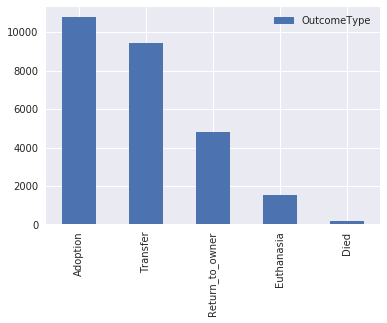

In [382]:
pd.DataFrame(shelter_pd.OutcomeType.value_counts()).plot(kind='bar')

Efectivamente, todas las filas parecen contener información de utilidad, por lo que no se necesita realizar limpieza alguna.

### <i>Animal type</i>

Se grafican las frecuencias para cada uno de los niveles del feature para detectar alguna anomalía en la información pero, como se puede ver, no la hay.

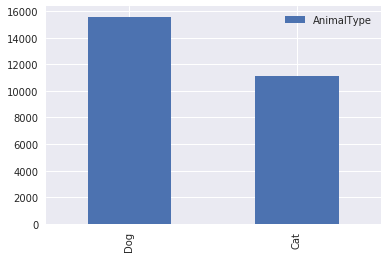

In [383]:
pd.DataFrame(shelter_pd.AnimalType.value_counts()).plot(kind='bar')

### <i>SexuponOutcome</i>

Como podemos ver en el Data Quality Report, hay un missing value. Sin embargo, se considera apropiado investigar qué niveles toma esta feature a partir de un gráfico de histograma.

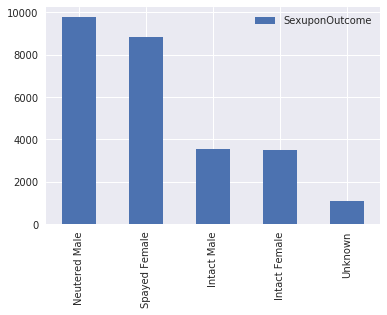

In [384]:
pd.DataFrame(shelter_pd.SexuponOutcome.value_counts()).plot(kind='bar')

Tanto el missing value, como los calificados como <i>unknown</i>, se les imputará un valor (ya que totalizan menos del 30% de los datos). Para ello necesito determinadas funciones genéricas como obtener la moda, contar la cantidad de veces que un valor aparece en una columna y demás.

In [385]:
import operator

def valueCountPandas(DF, column, value): 
    '''
        Function that counts the number of occurrences of a value in a given column
        First parameter is a pandas DataFrame
        Second parameter is the name of a column (String)
        Third parameter is the value that needs to be counted (String)
    '''
    count = 0
    columnIndex = DF.columns.get_loc(column)
    for (index, row) in DF.iterrows():
        if row[columnIndex] == value:
            count += 1
    return count

def valueCount(DF, column, value):
    '''
        Function that counts the number of occurrences of a value in a given column
        First parameter is a Spark DataFrame
        Second parameter is the name of a column (String)
        Third parameter is the value that needs to be counted (String)
    '''
    return DF.rdd.filter(lambda x: x[column] == value).count()

def missingValuesRemover(DF, column):
    '''
        Removes the rows with missing values in the given column
        First parameter is a pandas DataFrame
        Second parameter is the name of the column to be analyzed
    '''
    count = 0
    columnIndex = DF.columns.get_loc(column)
    for (index, row) in DF.iterrows():
        if str(row[columnIndex]).lower().split() == ['nan']:
            DF = DF.drop(index)
            count += 1
    print(str(count) + " row(s) removed")
    return DF

def selectDistinctPandas(DF, column):
    '''
        Selects all distinct value from column
        First parameter is a pandas DataFrame
        Second parameter is the name of the column to select the values from
    '''
    distinctList = []
    columnIndex = DF.columns.get_loc(column)
    for (index, row) in DF.iterrows():
        if row[columnIndex] not in distinctList:
            distinctList.append(row[columnIndex])
    return distinctList

def selectDistinct(DF, column):
    '''
        Selects all distinct value from column
        First parameter is a Spark DataFrame
        Second parameter is the name of the column to select the values from
    '''
    return DF.rdd.map(lambda x: x[column]).distinct().collect()

def getMode(DF, column):
    '''
        Gets mode of a given column in the dataset
        First parameter is a pandas DataFrame
        Second parameter is the name of the column to get the mode from
    '''
    countDict = {}
    selectDistinctList = selectDistinct(DF, column)
    for i in selectDistinctList:
        countDict[i] = valueCount(DF, column, i)
    return sorted(countDict.items(), key=operator.itemgetter(1))[-1][0]

In [386]:
# Check that the mode was calculated correctly. It should be Neutered Male according to the graph previously shown
print(getMode(shelter_df, "SexuponOutcome"))

Neutered Male


In [387]:
class FillMissingValues(Transformer, HasInputCol, HasOutputCol): 
    # Creates a column day
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(FillMissingValues, self).__init__()
        kwargs = self.__init__._input_kwargs
        self.setParams(**kwargs)
        
    @keyword_only 
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self.setParams._input_kwargs
        return self._set(**kwargs)
        
    def _transform(self, dataset):
        in_col = dataset[self.getInputCol()]
        out_col = self.getOutputCol()
        modeAttribute = getMode(shelter_df, self.getInputCol())
        udf = UserDefinedFunction(lambda x: fillMissingValues(x, modeAttribute), StringType())
        return dataset.withColumn(out_col, udf(in_col))
    
def fillMissingValues(input_value, mode):
    if (input_value.lower() == 'nan' or input_value.lower() == 'unknown'):
        return mode
    else:
        return input_value

### <i>AgeuponOutcome</i>

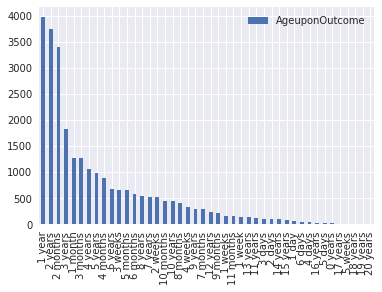

In [388]:
pd.DataFrame(shelter_pd['AgeuponOutcome'].value_counts()).plot(kind='bar')

### <i>Breed</i>

### <i>Color</i>

Se hace la limpieza de datos con la ayuda de <i>Pipelines</i>, y se obtiene un DataFrame de Spark. 

In [389]:
Name_transformer = NameTransformer(inputCol='Name', outputCol='Name')
DateTime_YearExtractor = YearExtractor(inputCol='DateTime', outputCol='Year')
DateTime_MonthExtractor = MonthExtractor(inputCol='DateTime', outputCol='Month')
DateTime_DayExtractor = DayExtractor(inputCol='DateTime', outputCol='Day')
SexuponOutcome_transformer = FillMissingValues(inputCol='SexuponOutcome', outputCol='SexuponOutcome')

In [390]:
shelter_pd = shelter_pd[['Name', 'DateTime', 'OutcomeType', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color']].astype(str)
shelter_df = sqlContext.createDataFrame(shelter_pd)
pipeline = Pipeline(stages=[Name_transformer, DateTime_DayExtractor, DateTime_MonthExtractor, DateTime_YearExtractor, SexuponOutcome_transformer])
model = pipeline.fit(shelter_df)
shelter_cleaned_df = model.transform(shelter_df)

In [391]:
(training, testing) = shelter_cleaned_df.randomSplit([0.8, 0.2])
training.take(2000)

#training = shelter_pd.sample(frac=0.8, replace=False)
#testing = shelter_pd.drop(training.index)
#print(training)

[Row(Name=0, DateTime=u'2013-10-01 10:39:00', OutcomeType=u'Transfer', AnimalType=u'Cat', SexuponOutcome=u'Neutered Male', AgeuponOutcome=u'1 week', Breed=u'Domestic Shorthair Mix', Color=u'Orange/White', Day=u'01', Month=u'10', Year=u'2013'),
 Row(Name=0, DateTime=u'2013-10-01 10:44:00', OutcomeType=u'Transfer', AnimalType=u'Cat', SexuponOutcome=u'Neutered Male', AgeuponOutcome=u'1 week', Breed=u'Domestic Shorthair Mix', Color=u'Orange/White', Day=u'01', Month=u'10', Year=u'2013'),
 Row(Name=0, DateTime=u'2013-10-01 11:12:00', OutcomeType=u'Transfer', AnimalType=u'Dog', SexuponOutcome=u'Neutered Male', AgeuponOutcome=u'3 years', Breed=u'Toy Poodle Mix', Color=u'White', Day=u'01', Month=u'10', Year=u'2013'),
 Row(Name=0, DateTime=u'2013-10-01 11:13:00', OutcomeType=u'Transfer', AnimalType=u'Dog', SexuponOutcome=u'Spayed Female', AgeuponOutcome=u'2 years', Breed=u'Boxer Mix', Color=u'Red/White', Day=u'01', Month=u'10', Year=u'2013'),
 Row(Name=0, DateTime=u'2013-10-01 12:34:00', Outcome

# KNN

In [392]:
import operator

def jaccardSimilarity(row1, row2):
    similarity = 0
    for i in range (len(row1)):
        #print(row1[i])
        #print(row2[i])
        if row1[i] == row2[i]:
            similarity += 1
    return float(similarity)/len(row1)

def getNeighbours(k, query, dataset):     ## Returns a list of the k nearest neighbour(s) of the query
    datasetWithoutTarget = dataset.drop("OutcomeType", 1)
    datasetWithoutTarget = datasetWithoutTarget.reset_index(drop=True)
    dictDistance = {}
    for i in range(len(datasetWithoutTarget)):
        dictDistance[i] = jaccardSimilarity(query, datasetWithoutTarget.ix[i])
    sorted_dictDistance = sorted(dictDistance.items(), key=operator.itemgetter(1))
    k_sorted_dictDistance = []
    for i in sorted_dictDistance[-k:]:
        k_sorted_dictDistance.append(i[0])
    return k_sorted_dictDistance


def KNN(neighbours, dataset):
    dictOutcome = {}
    for i in neighbours:
        if dataset.ix[i][0] in dictOutcome:
            dictOutcome[dataset.ix[i][0]] += 1
        else:
            dictOutcome[dataset.ix[i][0]] = 1
    sortedOutcomes = sorted(dictOutcome.iteritems(), key=operator.itemgetter(1), reverse=True)
    return sortedOutcomes[0][0]

## PS: Here, everything takes as an argument the dataset WITH the target feature
## The dataset must have the target feature (OutcomeType) as first column
## To make a KNN prediction for a query given a dataset --> KNN(getNeighbours(k, query, dataset), dataset)

In [403]:
iasf = testing.toPandas()
for i in range(0, len(iasf)):
    print(KNN(getNeighbours(10, iasf.ix[i], shelter_cleaned_df), shelter_cleaned_df))

TypeError: each col in the param list should be a string

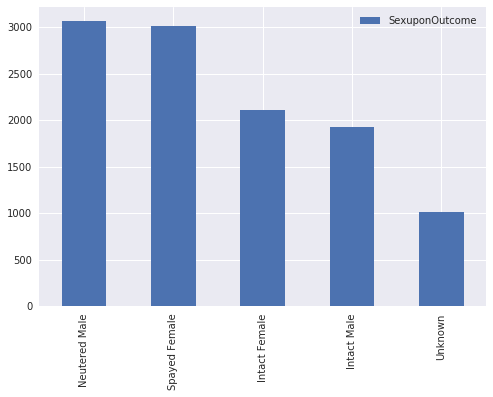

In [12]:
cats = shelter_pd.loc[shelter_pd['AnimalType'] == 'Cat']
pd.DataFrame(cats['SexuponOutcome'].value_counts()).plot(kind='bar')

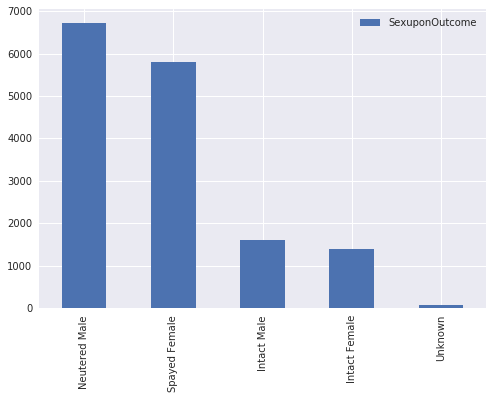

In [13]:
dogs= shelter_pd.loc[shelter_pd['AnimalType'] == 'Dog']
pd.DataFrame(dogs['SexuponOutcome'].value_counts()).plot(kind='bar')

In [21]:
not_missing_values_pd = shelter_pd.loc[(shelter_pd['SexuponOutcome'] != 'Unknown') & (shelter_pd['SexuponOutcome'] != 'NaN')]
# me aseguro de haber tomado todos los datos correctos
not_missing_values_pd.describe()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,25636,19001,25636,25636,12041,25636,25635,25622,25636,25636
unique,25636,6364,22345,5,16,2,4,44,1378,361
top,A705677,Max,2015-08-11 00:00:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7167,15518,9779,3853,7906,2700


##### Como se puede ver no hay missing values para SexuponOutcome. Acontinuacion lo demostrara un grafico.

In [ ]:
pd.DataFrame(not_missing_values_pd['SexuponOutcome'].value_counts()).plot(kind='bar')

##### Acontinuacion, se dividra este dataframe en dos 70% para entrenamiento y 30% para testing

In [ ]:
training = not_missing_values_pd.sample(frac=0.7, replace=False)
testing = not_missing_values_pd.drop(training.index)

In [278]:
print(getMode(shelter_df, "SexuponOutcome"))

Neutered Male


In [ ]:
shelter_pd = missingValuesRemover(shelter_pd, "AgeuponOutcome")
shelter_pd = missingValuesRemover(shelter_pd, "SexuponOutcome")
del shelter_pd['AnimalID']
del shelter_pd['OutcomeSubtype']
del shelter_pd['Name']

### Part II: Indexation

In [ ]:
shelter_pd[['DateTime', 'OutcomeType', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color']] = shelter_pd[['DateTime', 'OutcomeType', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color']].astype(str)
shelter_df = sqlContext.createDataFrame(shelter_pd)

## Creating a Spark Dataframe from the Pandas Dataframe in order to use it with the Decision Tree model.

In [88]:
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType, LongType, StringType


class AgeuponOutcomeTransformer(Transformer, HasInputCol, HasOutputCol): 
    # Does binning using the module of the division
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(AgeuponOutcomeTransformer, self).__init__()
        kwargs = self.__init__._input_kwargs
        self.setParams(**kwargs)
        
    @keyword_only 
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self.setParams._input_kwargs
        return self._set(**kwargs)
        
    def _transform(self, dataset):
        in_col = dataset[self.getInputCol()]
        out_col = self.getOutputCol()
        udf = UserDefinedFunction(lambda x: category_func(x), StringType())
        return dataset.withColumn(out_col, udf(in_col))

def category_func(in_value):
    if (in_value):
        age_in_days = 0
        splited_value = in_value.split(' ')        
        if (splited_value[1] == 'years' or splited_value[1] == 'year'):
            age_in_days = int(splited_value[0])*365
        elif(splited_value[1] == 'months' or splited_value[1] == 'month'):
            age_in_days = int(splited_value[0])*30
        elif(splited_value[1] == 'weeks' or splited_value[1] == 'week'):
            age_in_days = int(splited_value[0])*7
                
        if (age_in_days > 0 and age_in_days <= 365):
            return 'young'
        elif (age_in_days > 365 and age_in_days <= 365*3):
            return 'young_adult'
        elif (age_in_days > 365*3 and age_in_days <= 365*7):
            return 'adult'
        elif (age_in_days > 365*7 and age_in_days <= 365*10):
            return 'old_adult'
        elif (age_in_days > 365*10):
            return 'old'
    else:
        return 'None'

In [ ]:
class BinningTransformer(Transformer, HasInputCol, HasOutputCol): 
    # Does binning using the module of the division
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(BinningTransformer, self).__init__()
        kwargs = self.__init__._input_kwargs
        self.setParams(**kwargs)
        
    @keyword_only 
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self.setParams._input_kwargs
        return self._set(**kwargs)
        
    def _transform(self, dataset):
        in_col = dataset[self.getInputCol()]
        out_col = self.getOutputCol()
        udf = UserDefinedFunction(lambda x: bin_func(x), DoubleType())
        return dataset.withColumn(out_col, udf(in_col))

def bin_func(in_value):
    if (in_value):
        age_in_days = 0
        splited_value = in_value.split(' ')        
        if (splited_value[1] == 'years' or splited_value[1] == 'year'):
            age_in_days = int(splited_value[0])*365
        elif(splited_value[1] == 'months' or splited_value[1] == 'month'):
            age_in_days = int(splited_value[0])*30
        elif(splited_value[1] == 'weeks' or splited_value[1] == 'week'):
            age_in_days = int(splited_value[0])*7
                
        if (age_in_days > 0 and age_in_days <= 365):
            return 1.0
        elif (age_in_days > 365 and age_in_days <= 365*3):
            return 2.0
        elif (age_in_days > 365*3 and age_in_days <= 365*7):
            return 3.0
        elif (age_in_days > 365*7 and age_in_days <= 365*10):
            return 4.0
        elif (age_in_days > 365*10):
            return 5.0
    else:
        return 0.0

In [293]:
## Here are all the indexers we're gonna use in the pipeline:
#OutcomeType_indexer = StringIndexer(inputCol="OutcomeType", outputCol="OutcomeType_idx")
#AnimalType_indexer = StringIndexer(inputCol="AnimalType", outputCol="AnimalType_idx")
#SexuponOutcome_indexer = StringIndexer(inputCol="SexuponOutcome", outputCol="SexuponOutcome_idx")
#Breed_indexer = StringIndexer(inputCol="Breed", outputCol="Breed_idx")
#Color_indexer = StringIndexer(inputCol="Color", outputCol="Color_idx")
#Age_indexer = StringIndexer(inputCol='AgeuponOutcome', outputCol='AgeuponOutcome_idx')
#Bin_transformer = BinningTransformer(inputCol='AgeuponOutcome', outputCol='AgeuponOutcome_binned')
#AgeuponOutcome_transformer = AgeuponOutcomeTransformer(inputCol='AgeuponOutcome', outputCol='AgeuponOutcome_category')

Name_transformer = NameTransformer(inputCol='Name', outputCol='Name')
DateTime_YearExtractor = YearExtractor(inputCol='DateTime', outputCol='Year')
DateTime_MonthExtractor = MonthExtractor(inputCol='DateTime', outputCol='Month')
DateTime_DayExtractor = DayExtractor(inputCol='DateTime', outputCol='Day')
SexuponOutcome_transformer = FillMissingValues(inputCol='SexuponOutcome', outputCol='SexuponOutcome')

## Should we use OneHotEncoder or StringIndexer for continuous features?
## It looks like we're using StringIndexer more for stuff like boolean values and
## OneHotEncoder for actual categorical features.. But not sure
## Anyway if it's actally OneHotEncoder that we need to use, we just need to add
## One OneHotIndexer and use the OutcomeType_idx we just created as inputCol..

In [294]:
#pipeline = Pipeline(stages=[OutcomeType_indexer, AnimalType_indexer, SexuponOutcome_indexer, Breed_indexer, Color_indexer, AgeuponOutcome_transformer, Bin_transformer, DateTime_YearExtractor, DateTime_MonthExtractor, DateTime_DayExtractor])
shelter_pd = shelter_pd[['Name', 'DateTime', 'OutcomeType', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color']].astype(str)
shelter_df = sqlContext.createDataFrame(shelter_pd)
pipeline = Pipeline(stages=[Name_transformer, DateTime_DayExtractor, DateTime_MonthExtractor, DateTime_YearExtractor, SexuponOutcome_transformer])
model = pipeline.fit(shelter_df)
shelter_cleaned_df = model.transform(shelter_df)

In [193]:
#shelter_df_idx = model.transform(shelter_df)
#shelter_df_idx.show()

In [ ]:
shelter_df_only_idx = shelter_df_idx
shelter_df_only_idx = shelter_df_only_idx.drop('OutcomeType', 'AnimalType', 'SexuponOutcome', 'Breed', 'Color')

## Dropping the tables that are still categorical because they're no use to us.

In [ ]:
shelter_df_only_idx.registerTempTable("shelter")
sqlContext.sql("SELECT OutcomeType_idx, AnimalType_idx, SexuponOutcome_idx, Breed_idx, Color_idx, AgeuponOutcome_binned FROM shelter").show()

## Showing all the indexed tables

#################################
#################################


OKAY GUYS, 

Tenemos que cambiar la columna fecha y edad para poder usarlo con decision tree


#################################
#################################

### Para realizar naive base convertimos el cleaned dataframe de spark a pandas

In [ ]:
shelter_df_only_category = shelter_df_idx
shelter_df_only_category = shelter_df_only_category.drop('DateTime', 'OutcomeType_idx', 'AnimalType_idx', 'SexuponOutcome_idx', 'Breed_idx', 'Color_idx','AgeuponOutcome_binned', 'Ageuponoutcome')
shelter_cleaned_df = shelter_df_only_category.toPandas()
shelter_cleaned_df

In [ ]:
shelter_cleaned_df.loc[shelter_cleaned_df['AnimalType'] == 'Cat']

In [ ]:
cats = shelter_cleaned_df.loc[shelter_cleaned_df['AnimalType'] == 'Cat']
cats.describe()
#cats.loc[cats['SexuponOutcome'] == 'Neutered Male'].describe()

In [ ]:
pd.DataFrame(cats['SexuponOutcome'].value_counts()).plot(kind='bar')

In [ ]:
dog = shelter_cleaned_df.loc[shelter_cleaned_df['AnimalType'] == 'Dog']
dog.describe()

In [ ]:
pd.DataFrame(dog['SexuponOutcome'].value_counts()).plot(kind='bar')

In [92]:
shelter_df["Name"]

Column<Name>